<a href="https://colab.research.google.com/github/renadalahmadi/BigData-and-AI/blob/main/Arabic_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Arabic Natural Language 

Renad Alahmadi

-  Importing Packages 


In [40]:
import numpy as np
import math
import re
import pandas as pd
import random
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
import stanza
import json



 1- Converting the dataset from TSV -> CSV 

In [4]:

tsv_file='/content/train_Arabic_tweets_positive_20190413.tsv'
 
# reading given tsv file
csv_table=pd.read_table(tsv_file,sep='\t')
 
# converting tsv file into csv
csv_table.to_csv('/content/train_Arabic_tweets_positive_.csv',index=False)
 
# output
print("Successfully made csv file")

Successfully made csv file


 2- Concatenation of the train and test datasets 

In [6]:
trainPos = pd.read_csv('/content/train_Arabic_tweets_positive_.csv' , names=['sentiment', 'text'])
trainNeg = pd.read_csv('/content/train_Arabic_tweets_negative_.csv' , names=['sentiment', 'text'])

# ------------------------------------------------------------------------------------------------

testPos = pd.read_csv('/content/train_Arabic_tweets_positive_.csv' , names=['sentiment', 'text'])
testNeg = pd.read_csv('/content/train_Arabic_tweets_negative_.csv' , names=['sentiment', 'text'])

In [7]:
conct_1 = [trainPos, trainNeg]
conct_2 = [testPos, testNeg]


traindataset = pd.concat(conct_1)
testdataset = pd.concat(conct_2)

In [8]:
# let's check : 
print(traindataset)
print(testdataset)

      sentiment                                               text
0           pos  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1           pos  وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...
2           pos                                    من الخير نفسه 💛
3           pos  #زلزل_الملعب_نصرنا_بيلعب كن عالي الهمه ولا ترض...
4           pos  الشيء الوحيد الذي وصلوا فيه للعالمية هو : المس...
...         ...                                                ...
22509       neg  كيف ترى أورانوس لو كان يقع مكان القمر ؟ 💙💙 كوك...
22510       neg                                  احسدك على الايم 💔
22511       neg                            لأول مرة ما بنكون سوا 💔
22512       neg                                 بقله ليش يا واطي 🤔
22513       neg  قد طال صبري في النوى إذ تركتني كئيبا ؛ غريبا ب...

[45275 rows x 2 columns]
      sentiment                                               text
0           pos  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...
1           pos  وفي النهاية لن يبقى

In [ ]:
traindataset.info()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


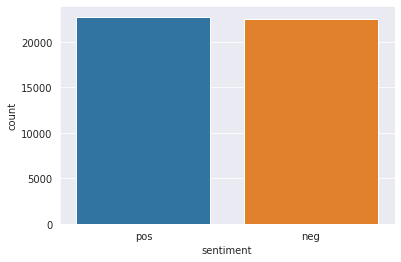

In [9]:
# ploting the counts of each class
sns.set_style("darkgrid")
sns.countplot(traindataset["sentiment"])

- There's an obvious balance between the neg and pos classes which is good and the model training.

 3- Cleaning the dataset  

In [42]:
nltk.download('stopwords')
stopwords_list = stopwords.words('arabic')
st = ISRIStemmer()
stop=[]
for w in stopwords_list:
    rootWord=st.stem(w)
    stop.append(rootWord)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
nltk.download('punkt')
def process_text(text):
    stemmer = nltk.ISRIStemmer()
    word_list = nltk.word_tokenize(text)
    #remove arabic stopwords
    word_list = [ w for w in word_list if not w in stopwords_list ]
    #remove digits
    word_list = [ w for w in word_list ]
    #stemming
    word_list = [stemmer.stem(w) for w in  word_list]
    return ' '.join(word_list) 


def clean_text(text):  

    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']
    #remove tashkeel
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel,"", text)
  
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)
    
    text = re.sub(r"[^\w\s]", '', text)
    #remove english words
    text = re.sub(r"[a-zA-Z]", '', text)
    #remove spaces
    text = re.sub(r"\d+", ' ', text)
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r"\t+", ' ', text)
    text = re.sub(r"\r+", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    #remove repetetions
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    text = text.strip()
    
    return process_text(text) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [46]:
#. now let'st apply the cleaning on the train & test sets
traindataset["text"].apply(clean_text)
testdataset["text"].apply(clean_text)

0        تحل نود ان نقل الي دعء لله بحث فين قوه انن كسر...
1            وفي نهي يبق معك حدل راي جمل روح امالمنبهر مظا
2                                                  خير نفس
3        زلزل لعب نصر لعب علي همه ترض بغر قمه جرد ساع ل...
4               شيء وحد وصل علم سير تري كان شجع درد ضد نصر
                               ...                        
22500                                             مش هتلاق
22501                                  غفر الل عظم ولل غصه
22502        انا حيل قدر وقف بوظ شوكول شور هول لته بدب فيه
22506                      اكر مره اني اكن حرس وحظ ديم يخل
22510                                          حسد علي ايم
Name: text, Length: 29554, dtype: object

 4- Splitting the dataset and doing some kind of Pre-Processing such as 
 - Dropping duplicates 
 - Encoding the data --> to labeles 


In [47]:
X_train = traindataset.text
X_test = testdataset.text
y_train = traindataset['sentiment']
y_test = testdataset['sentiment']

In [48]:
# Drop dulicates if there's any 
X_train.drop_duplicates()

# Encoding the data 
# Changes the columns that we have in the dataframe for th Y instead o having text into number lables 
enc= LabelEncoder()
y_train=enc.fit_transform(y_train)
y_test=enc.transform(y_test)

In [49]:
# After dropping the dublicates 
traindataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29554 entries, 0 to 22510
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  29554 non-null  object
 1   text       29554 non-null  object
dtypes: object(2)
memory usage: 692.7+ KB


 4- Modelling the Predictions  


In [50]:
'''
creating Pipeline --> 
1- Vectorizing the data using TF_IDF 
2- Training using SVC because it works the best with NLP 
'''
from sklearn.pipeline import make_pipeline

vectorizer=TfidfVectorizer(analyzer='char_wb',ngram_range=(3,5),min_df=0.01,max_df=0.3)
model =  SVC(kernel='rbf')
pipe = make_pipeline(vectorizer,model)


pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=0.3, min_df=0.01,
                                 ngram_range=(3, 5))),
                ('svc', SVC())])

In [51]:
y_pred=pipe.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     15095
           1       0.94      0.96      0.95     14459

    accuracy                           0.95     29554
   macro avg       0.95      0.95      0.95     29554
weighted avg       0.95      0.95      0.95     29554



very good results I believe!! 

Finally, it worked with me :)